# 01 - CleanLab

Here we go through auditing an image classification dataset with CleanLab.
Multiple packages are available from CleanLab depending on the abstraction level wanting to use.
This showcases the highest abstraction by relying on `DataLab`.

In this notebook we use cleanlab's Datalab audit to detect issues in a subset of the famous [Oxford-PetIIIT dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
CleanLab works with any ML model trained on your data and uses outputs from this model to detect issues in your data. 

If you have your own image collection to analyze then you need to perform the model training aswell, otherwise we provide pre-computed outputs for the Oxford-PetIIIT dataset.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cleanlab/examples/blob/master/datalab_image_classification/datalab.ipynb)

## Import necessary libraries and download dataset

In [5]:
!pip install -r requirements.txt

In [1]:
from cleanlab import Datalab

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset

import torch
from torchvision import datasets, transforms
from typing import Union, Tuple, Dict, List
from pathlib import Path

import sys

sys.path.append("../")

from utils import get_oxford_pets3t

We start by downloading our dataset to analyze.

Either you want to analyze your own collection or you can analyze Oxford PetIIIT.

In [2]:
dataset, df = get_oxford_pets3t(root_path="data", return_dataframe=True)
dataset

Oxford PetIIIT already downloaded to `data`.


Dataset ImageFolder
    Number of datapoints: 7390
    Root location: data

In [ ]:
# 2nd option -> analyze your own data
# dataset = ImageFolder(root_path='path/to/dataset')

## Visualize the data

Let's look at some random images in the dataset.

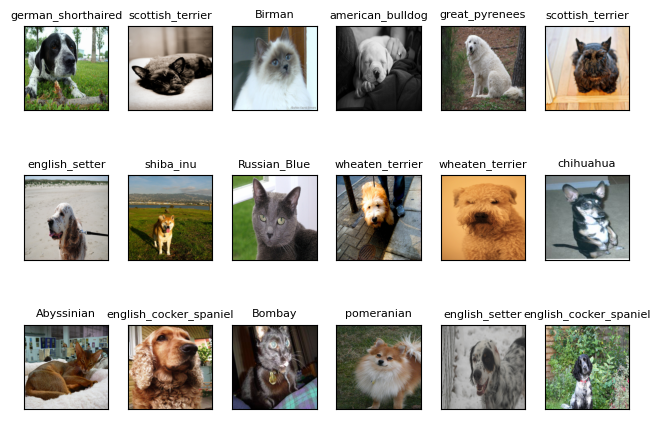

In [3]:
fig, axes = plt.subplots(3, 6)
for h_idx, h_ax in enumerate(axes):
    for v_idx, ax in enumerate(h_ax):
        index = np.random.randint(0, high=len(dataset))
        ax.imshow(transforms.Resize((256, 256))(dataset[index][0]))
        ax.set_title(dataset.classes[dataset[index][1]], fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        index += 1
fig.tight_layout()
plt.show()

## Load pre-computed features and predicted probabilities

Next we load the pre-computed outputs from our model; refer to [01A_CleanLab_Train_Classifier.ipynb](TODO) to see how they were produced or to produce your own for a custom dataset. 

We load two arrays: vector feature embeddings and predicted class probabilities for each image in the dataset.
The predicted class probabilities were obtained from a fine-tuned ResNet-50 model with 5-folds cross-validation, 
and the features were generated using the same model trained on the first 4 folds of the dataset.

Note that Datalab can be run with fewer outputs from your model, you do not need to provide both features and predictions. 
But Datalab can detect more types of issues when provided with more types of outputs from your model. 
The better your model, the more accurately Datalab can detect data issues.

In [ ]:
features = np.load("data/features.npy")
pred_probs = np.load("data/pred_probs.npy")

## Use Datalab to find issues in the dataset

We create a Datalab object with the dataset, specifying the name of the column containing the given label for each image.
We then use the `find_issues` method to audit the quality of the dataset, using the provided feature embeddings and predicted class probabilities.

Finally, we generate a report summarizing the issues detected in this dataset.

In [70]:
lab = Datalab(data=df, label_name="label")
lab.find_issues(features=features, pred_probs=pred_probs)

NameError: name 'features' is not defined

In [8]:
lab.report(include_description=False)

Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
       outlier          24
near_duplicate          16
         label           6
       non_iid           1

Dataset Information: num_examples: 622, num_classes: 5


---------------------- outlier issues ----------------------

Number of examples with this issue: 24
Overall dataset quality in terms of this issue: 0.7234

Examples representing most severe instances of this issue:
     is_outlier_issue  outlier_score
511              True       0.409035
235              True       0.413877
389              True       0.414632
619              True       0.422202
390              True       0.425272


------------------ near_duplicate issues -------------------

Number of examples with this issue: 16
Overall dataset quality in terms of this issue: 0.2578

Examples representing most severe instances of this issue:
     is_near_duplicate_issue  near_duplicate_score near_duplicate_sets  distance

## Review the different issue types

Here, we retrieve the examples exhibiting different types of issues found in the dataset (label, outlier, and near_duplicate). This allows us to focus on one type of issue at a time.


We define a function, `make_image_plot` to visualize images, and provide some context to images that might have issues.

In [9]:
def make_image_plot(ax, img, label=None, additional_info=None):
    title = ""
    if label is not None:
        title = "Label {}".format(label)

    if additional_info is not None:
        title += "\n" + additional_info

    if title:
        ax.set_title(title)
    ax.axis("off")
    ax.imshow(img, cmap="gray")

## Visualizing issues

The remainder of this notebook is dedicated to visualizing the different types of issues found in the dataset.

Generally, this involves:

1. Querying one of the `issues` dataframes to find examples that are considered to have an issue or not.

2. Sorting the filtered results by their associated issue quality scores in ascending order.

3. Examining the sorted results and creating subplots of the images with any relevant information or context.

## Near duplicate issues

In this section, we display examples from the dataset that are considered to be nearly duplicated.
The `near_duplicate_issues` DataFrame tells use which examples are considered to have near duplicates, and we can sort them via the `near_duplicate_score` which quantifies how severe this issue is for each image (lower values indicate more severe intances of a type of issue).

This allows us to visualize examples in the dataset that are considered near duplicates, along with their near-duplicate counterparts.

In [10]:
near_duplicate_issues = lab.get_issues("near_duplicate")

near_duplicate_df = near_duplicate_issues.query("is_near_duplicate_issue").sort_values(
    "near_duplicate_score", ascending=True
)

near_duplicate_df

is_near_duplicate_issue  near_duplicate_score near_duplicate_sets  \
109                     True          0.000000e+00               [110]   
110                     True          0.000000e+00               [109]   
238                     True          0.000000e+00               [393]   
391                     True          0.000000e+00               [392]   
392                     True          0.000000e+00               [391]   
393                     True          0.000000e+00               [238]   
512                     True          9.225953e-14               [513]   
513                     True          9.225953e-14               [512]   
402                     True          6.470183e-03               [415]   
415                     True          6.470183e-03               [402]   
237                     True          7.418116e-03               [239]   
239                     True          7.418116e-03               [237]   
515                     True          2.168114e-02               [530]   
530                     True          2.168114e-02               [515]   
134                     True          2.611929e-02               [210]   
210                     True          2.611929e-02               [134]   

     distance_to_nearest_neighbor  
109                  0.000000e+00  
110                  0.000000e+00  
238                  0.000000e+00  
391                  0.000000e+00  
392                  0.000000e+00  
393                  0.000000e+00  
512                  9.225953e-14  
513                  9.225953e-14  
402                  6.470273e-03  
415                  6.470273e-03  
237                  7.418252e-03  
239                  7.418252e-03  
515                  2.168454e-02  
530                  2.168454e-02  
134                  2.612523e-02  
210                  2.612523e-02

We define a `plot_near_duplicate_images` function that takes a row from the `near_duplicate_issues` DataFrame as input. This function:

1. Retrieves the original image and its given label based on the row index.

2. Creates a subplot for the original image and each of its near duplicates.

To avoid cluttering the notebook with the same images, we add some logic for tracking previously displayed images and mainly displaying new images.

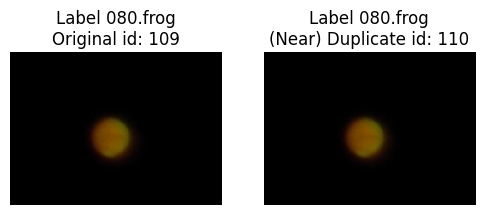

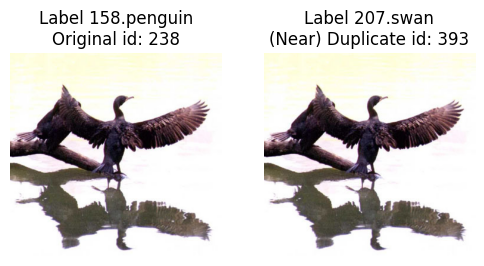

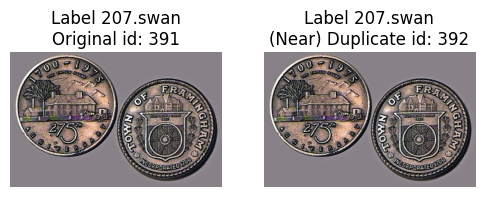

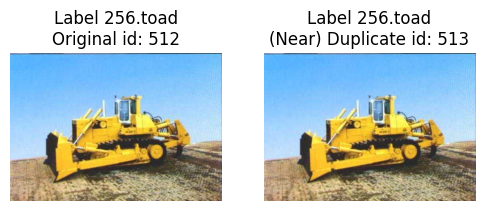

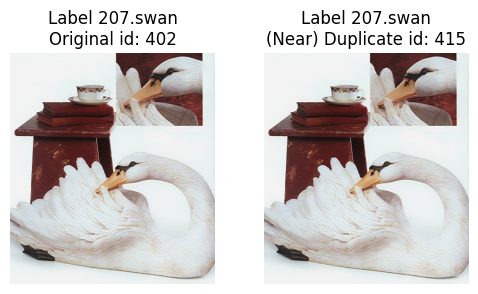

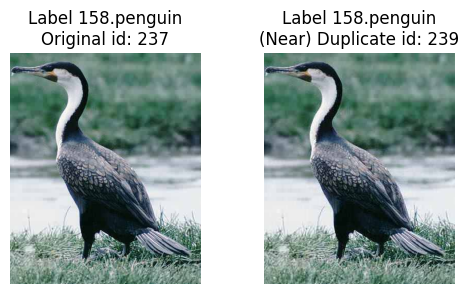

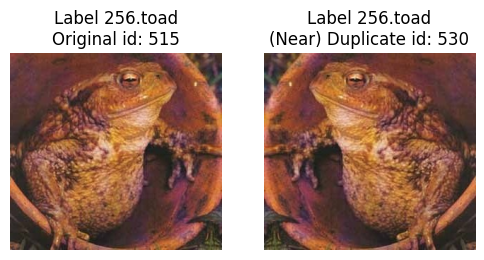

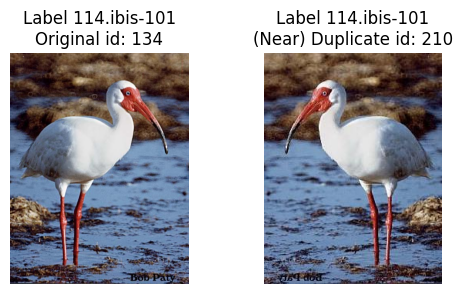

In [11]:
seen_ids = set()


def plot_near_duplicate_images(row):
    label_issues = lab.get_issues("label")

    def get_image_and_given_label(idx):
        image = dataset_hf[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        return image, label

    img1_idx = row.name
    if img1_idx in seen_ids:
        return

    duplicate_images = row.near_duplicate_sets
    # how many near duplicates have we seen so far?
    seen_near_duplicates = seen_ids.intersection(duplicate_images)
    # if we have seen all near duplicates, we can skip the rest
    if len(seen_near_duplicates) == len(duplicate_images):
        return

    # If the set has more than 5 near duplicates, at least half of them should be new
    if (
        len(duplicate_images) > 5
        and len(seen_near_duplicates) > len(duplicate_images) / 2
    ):
        return

    num_figures = len(duplicate_images) + 1
    _, ax = plt.subplots(1, num_figures, figsize=(num_figures * 3, 3))
    original_image, label = get_image_and_given_label(img1_idx)
    make_image_plot(
        ax[0], original_image, label, additional_info=f"Original id: {img1_idx}"
    )

    seen_ids.add(img1_idx)

    for i, duplicate_image in enumerate(duplicate_images):
        img2_idx = int(duplicate_image)
        if True:
            img2, label2 = get_image_and_given_label(img2_idx)
            is_near_duplicate = near_duplicate_issues.loc[img2_idx][
                "is_near_duplicate_issue"
            ]
            additional_info = ""
            if is_near_duplicate:
                additional_info = f"(Near) Duplicate id: {img2_idx}"
            make_image_plot(ax[i + 1], img2, label2, additional_info=additional_info)
            seen_ids.add(img2_idx)


near_duplicate_df.apply(plot_near_duplicate_images, axis=1)
plt.show()

## Label issues


In this section, we focus on visualizing examples in the dataset that have label errors. Label errors occur when the given label for an image is incorrect, usually due to mislabeling during dataset creation. Some of these examples are available at [labelerrors.com](https://labelerrors.com) under the Caltech-256 dataset.

We filter the `label_issues` DataFrame to find examples that are considered to have label errors.

Then, we sort the filtered results by their label quality score in ascending order, where examples with the lowest scores are more likely to have label errors.

In [12]:
label_issues = lab.get_issues("label")

labels_df = label_issues.query("is_label_issue").sort_values(
    "label_score", ascending=True
)
labels_df.head(10)

is_label_issue  label_score   given_label predicted_label
514            True     0.000013      256.toad     158.penguin
113            True     0.000140  114.ibis-101        080.frog
523            True     0.009674      256.toad        080.frog
60             True     0.013863      080.frog        256.toad
565            True     0.129137      256.toad        080.frog
537            True     0.181614      256.toad        080.frog

We define a `plot_label_issues` function to visualize the examples with label errors. This function:

1. Retrieves the image, given label, and predicted label based on the row index.

    - Additionally, we fetch the file name of the image to use as the title of the plot when necessary.

2.  Creates a plot for the image using the `make_image_plot` function with the given label and additional information about the predicted label.

Finally, we apply the `plot_label_issues` function to each row of the filtered and sorted results.

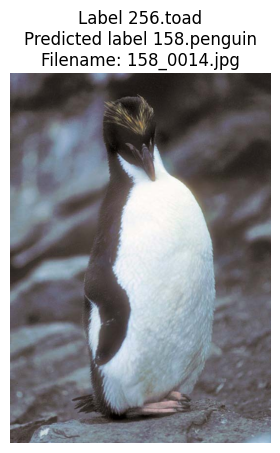

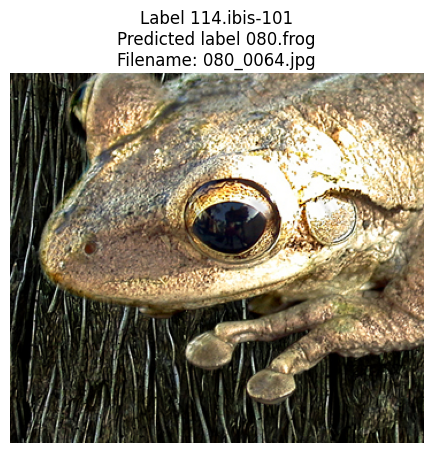

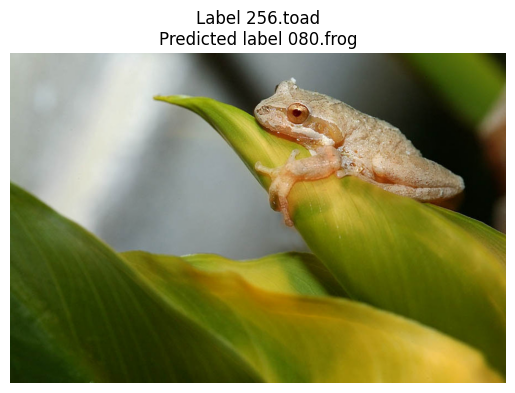

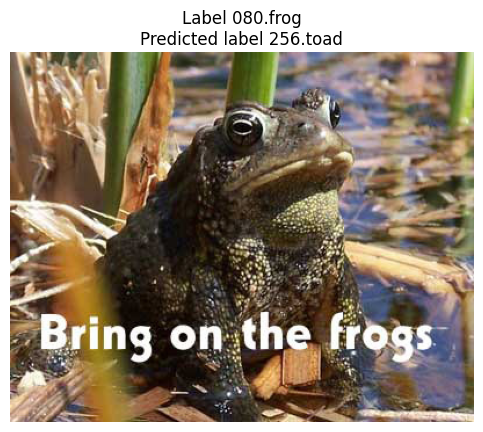

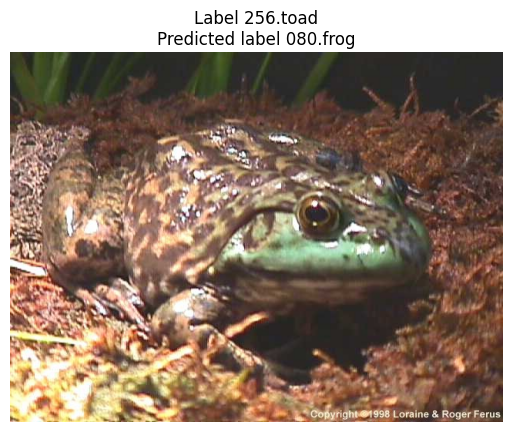

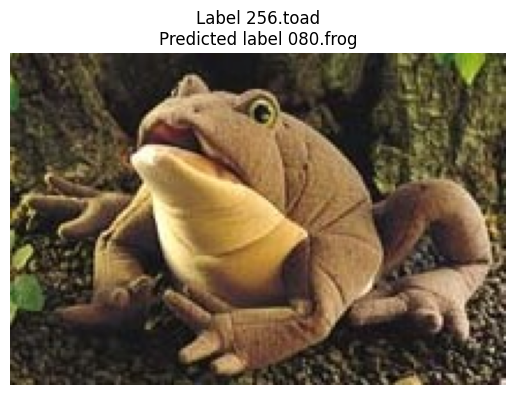

In [13]:
def plot_label_issues(row):
    idx = row.name
    image = dataset_hf[idx]["image"]
    image_filename = image.filename.split("/")[-1]
    label = label_issues.loc[idx]["given_label"]
    predicted_label = label_issues.loc[idx]["predicted_label"]

    filename_label = image_filename.split("_")[0]
    ax = plt.subplot(1, 1, 1)
    additional_info = f"Predicted label {predicted_label}"
    if label.split(".")[0] != filename_label:
        additional_info += f"\nFilename: {image_filename}"

    make_image_plot(ax, image, label, additional_info=additional_info)
    plt.show()


labels_df.apply(plot_label_issues, axis=1)
plt.show()

Cleanlab reveals a major problem in this dataset is many frogs/toads have been mislabeled as the other class.

## Outlier issues

In this section, we focus on reviewing atypical examples in the dataset. These are examples that are significantly different from the majority of the dataset, which may have an outsized impact on models fit to this data.

Similarly to the previous section, we filter the `outlier_issues` DataFrame to find examples that are considered to be outliers. We then sort the filtered results by their outlier quality score in ascending order, where examples with the lowest scores appear least typical based on the rest of the dataset.

In [14]:
outlier_issues = lab.get_issues("outlier")

outliers_df = outlier_issues.query("is_outlier_issue").sort_values(
    "outlier_score", ascending=True
)
outliers_df.head(10)

is_outlier_issue  outlier_score
511              True       0.409035
235              True       0.413877
389              True       0.414632
619              True       0.422202
390              True       0.425272
112              True       0.429464
387              True       0.432111
510              True       0.432864
388              True       0.435100
234              True       0.435130

To visualize the most anomalous examples, we:

We define a `plot_outlier_issues` function to visualize the examples that are most anomalous. This function:
that takes a row from the `outlier_issues` DataFrame as input. This function:

1. Retrieves the image, given label and sampled images from the same class, used for comparison.

2. Creates a subplot for the original image and the sampled images.

3. Uses the `make_image_plot` function to display the images with additional information about their labels.

The `plot_outlier_issues` function is applied to each row of the filtered and sorted results.

By visualizing these anomalous examples with some additional context, we can gain insights into the dataset's diversity and the potential challenges that these unusual examples may pose during model training and evaluation.

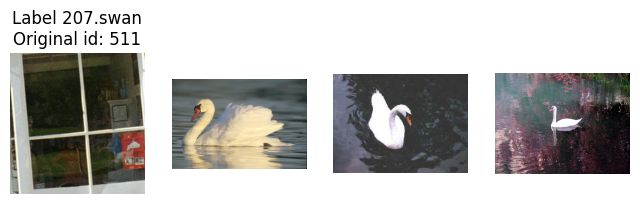

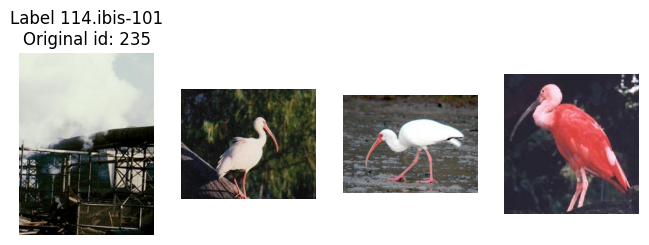

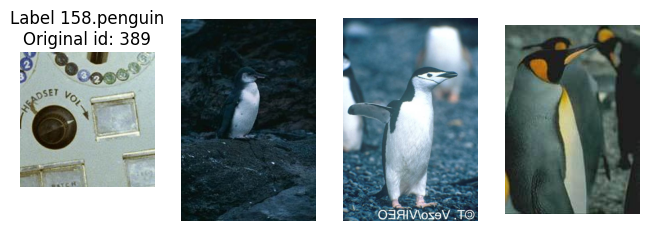

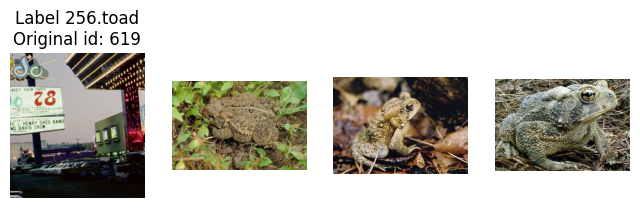

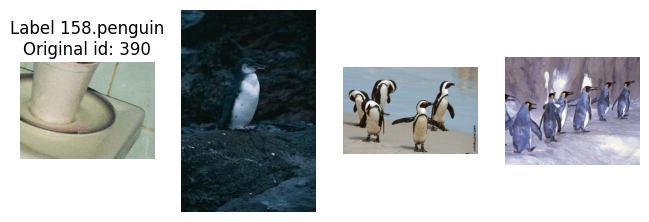

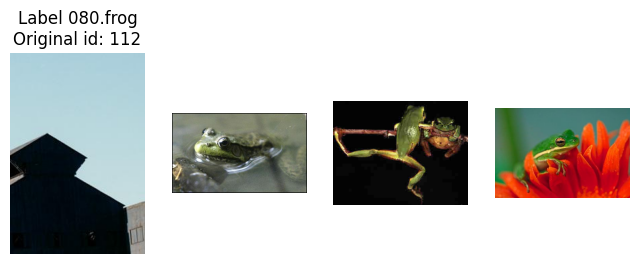

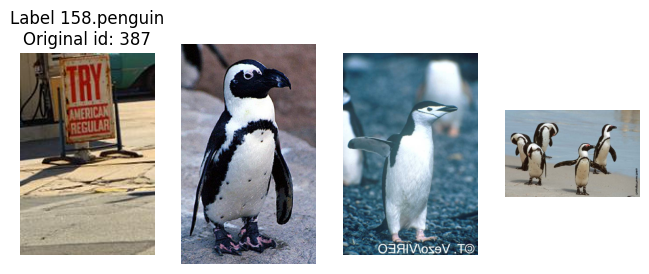

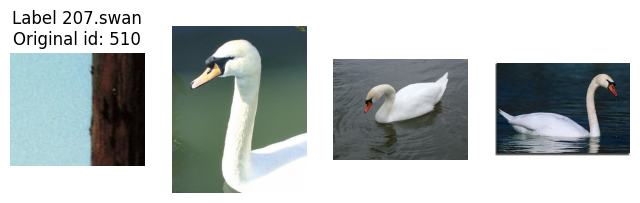

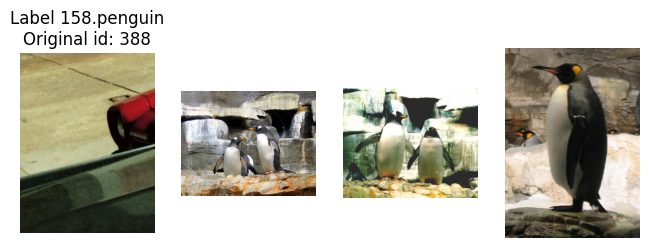

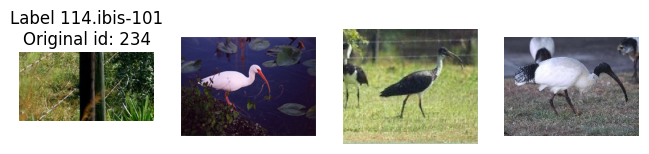

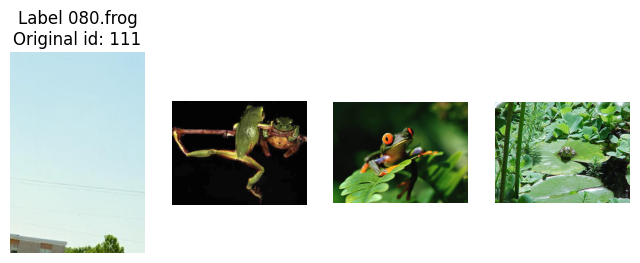

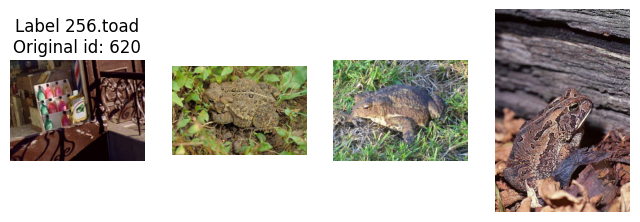

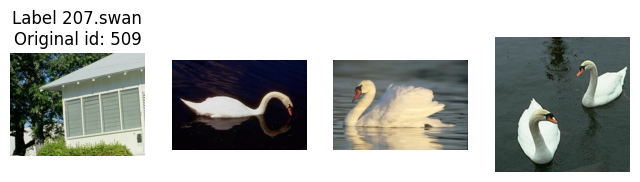

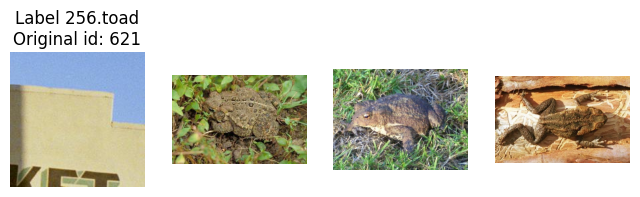

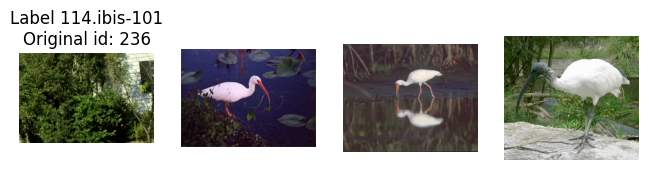

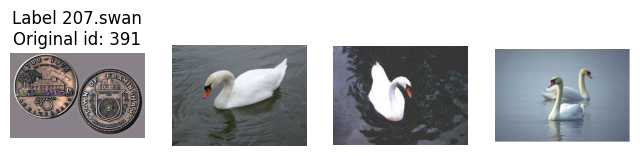

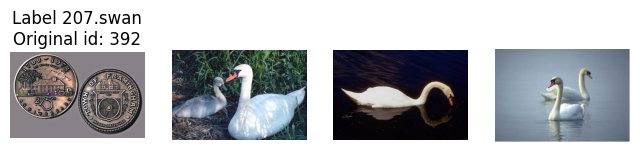

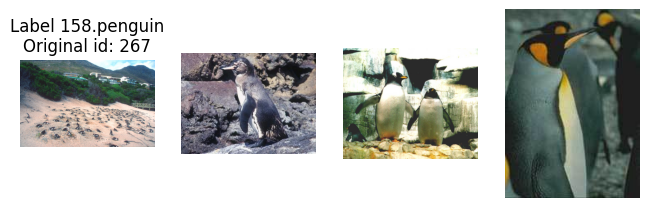

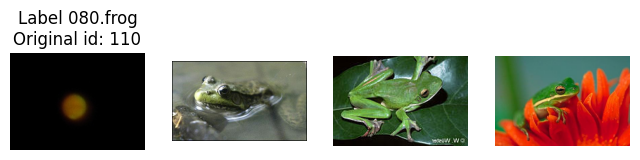

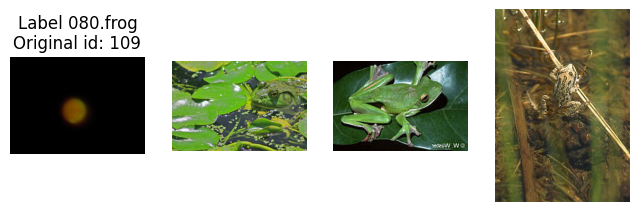

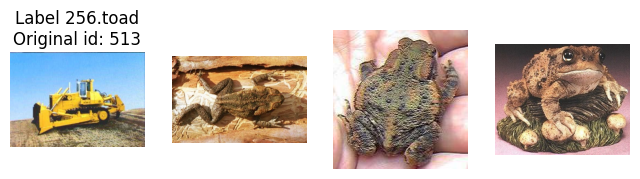

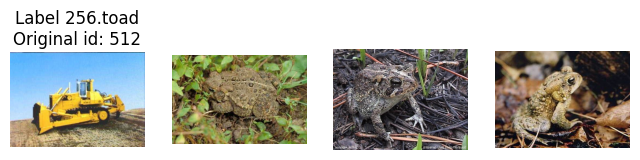

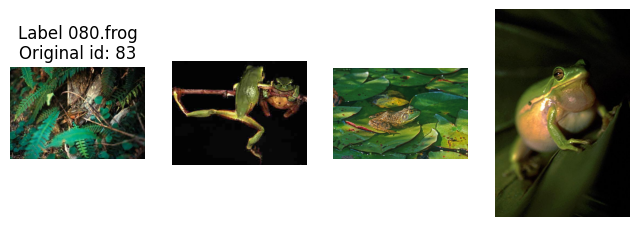

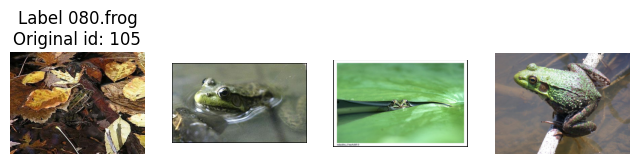

In [15]:
def plot_outlier_issues(row):
    label_issues = lab.get_issues("label")
    N_comparison_images = 3

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues)
            .query("given_label == @label and not is_outlier_issue")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[
            non_outlier_indices != index
        ]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][
            :N_comparison_images
        ]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset_hf[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset_hf[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[
            :N_comparison_images
        ]

        return image_from_dataset, corresponding_label, comparison_images

    idx = row.name
    image, label, comparison_images = get_image_given_label_and_samples(idx)
    _, ax = plt.subplots(1, N_comparison_images + 1, figsize=(8, 5))

    make_image_plot(ax[0], image, label, additional_info=f"Original id: {idx}")
    for i, comparison_image in enumerate(comparison_images):
        make_image_plot(ax[i + 1], comparison_image)
    plt.show()


outliers_df.apply(plot_outlier_issues, axis=1)
plt.show()

Cleanlab reveals this dataset actually contains many miscellaneous images which don't really belong to *any* of the classes for this dataset. Clearly it does not make sense to label such images with this constrained set of classes. 

## Examples that are both near duplicates and inconsistently labeled

In this section, we'll show examples in the dataset that have both near duplicates and label errors.

While the `is_label_error` column in the `label_issues` DataFrame is a more confident indicator of label errors, we use the disagreement between the given label and predicted label instead for demonstration purposes

These examples are particularly interesting because they have issues in multiple aspects and could potentially have a greater impact on model performance.

All we do differently in this section is:

- Filter the *joined* `label_issues` and `near_duplicate_issues` DataFrames to find examples that have both label errors and near duplicates.
   - Note: In the provided code, we use disagreement between the given label and predicted label instead of the `is_label_issue` flag to filter examples with label errors.

Sort the filtered results by their label quality score in ascending order, where examples with the lowest scores are more likely to have label errors.


In [16]:
label_issues, near_duplicate_issues = (
    lab.get_issues(name) for name in ["label", "near_duplicate"]
)

# query_expr = "is_label_issue and is_near_duplicate_issue"
query_expr = "given_label != predicted_label and is_near_duplicate_issue"  # Use disagreement instead of is_label_issue
near_duplicate_labels_df = (
    label_issues.join(near_duplicate_issues, how="outer")
    .query(query_expr)
    .sort_values("label_score", ascending=True)
)
near_duplicate_labels_df.head(10)

is_label_issue  label_score  given_label predicted_label  \
393           False     0.064230     207.swan     158.penguin   
238           False     0.104213  158.penguin        207.swan   
391           False     0.183093     207.swan        256.toad   

     is_near_duplicate_issue  near_duplicate_score near_duplicate_sets  \
393                     True                   0.0               [238]   
238                     True                   0.0               [393]   
391                     True                   0.0               [392]   

     distance_to_nearest_neighbor  
393                           0.0  
238                           0.0  
391                           0.0

We define a `plot_label_and_near_duplicate_issues` function that shows example images that have both issues. This function:

1. Retrieves the image, given label, and predicted label based on the row index.

2. Fetches the near duplicate images.

3. Checks if the image and its near duplicates have already been displayed. This avoids showing identical results multiple times.

4. Creates a subplot for the original image and each of its near duplicates.

The `plot_label_and_near_duplicate_issues` function is applied to each row of the joined, filtered and sorted results.

By visualizing these examples with both label errors and near duplicates, we can better understand the complex relationships between different types of issues in the dataset and their potential impact on model training and evaluation.

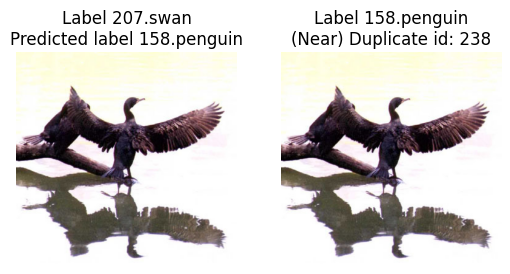

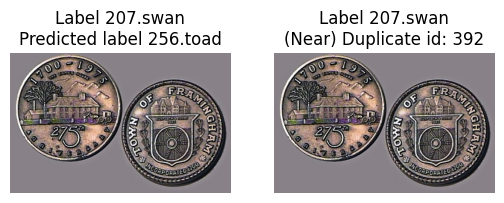

In [17]:
seen_id_pairs = set()


def plot_label_and_near_duplicate_issues(row):
    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset_hf[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    idx = row.name
    image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
    duplicate_images = row.near_duplicate_sets

    id_collection = tuple(sorted([idx] + list(duplicate_images)))
    if id_collection in seen_id_pairs:
        return
    _, ax = plt.subplots(
        1, len(duplicate_images) + 1, figsize=((len(duplicate_images) + 1.5) ** 2, 3)
    )
    make_image_plot(
        ax[0], image, label, additional_info=f"Predicted label {predicted_label}"
    )
    for i, duplicate_image in enumerate(duplicate_images):
        img2, label2, predicted_label2 = get_image_and_given_label_and_predicted_label(
            int(duplicate_image)
        )
        if (idx, duplicate_image) in seen_id_pairs or (
            duplicate_image,
            idx,
        ) in seen_id_pairs:
            continue
        seen_id_pairs.add((idx, duplicate_image))
        make_image_plot(
            ax[i + 1],
            img2,
            label2,
            additional_info=f"(Near) Duplicate id: {duplicate_image}",
        )
    seen_id_pairs.add(id_collection)


near_duplicate_labels_df.apply(plot_label_and_near_duplicate_issues, axis=1)
plt.show()

Using Datalab to audit your dataset is super easy! If it detects meaningful issues, consider how to fix them, or whether you want to remove certain examples from the dataset entirely. These decisions are important for you to  effectively model your data, but you first need to know what types of issues are lurking in the dataset. 

## Image specific issues

Cleanlab can also detect issues that are specific to computer vision datasets such as images which are: dark, light, blurry, low_information, odd_aspect_ratio, odd_size, grayscale, etc.  Image-specific issues are internally detected via [cleanvision](https://github.com/cleanlab/cleanvision) (check this package out to learn more about these issues).
To check for image-specific issues in cleanlab with a Hugging Face Dataset, simply specify the argument `image_key`: the name of the field containing the raw images in the dataset. This name can be found using `Dataset.features`, and for our dataset here happens to be called `image`.

First install cleanlab with some optional  dependencies that contain the image-specific functionality.

In [ ]:
!pip install "cleanlab[image]"

In [19]:
dataset_hf.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['080.frog', '114.ibis-101', '158.penguin', '207.swan', '256.toad'], id=None)}

Now we again simply run  `Datalab.find_issues()` this time specifying the `image_key` argument to inform cleanlab this is an image dataset. Datalab will now automatically check for image-specific issues along with the other issue-types it considers for all datasets (regardless of their modality).

In [20]:
lab = Datalab(data=dataset_hf, label_name="label", image_key="image")
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/622 [00:00<?, ?it/s]


Audit complete. 48 issues found in the dataset.


The resulting issue report looks as before, except now there are additional sections for new image-specific issues that have been detected in the dataset.

Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
         outlier          24
  near_duplicate          16
           label           6
         non_iid           1
odd_aspect_ratio           1
          blurry           0
            dark           0
       grayscale           0
           light           0
 low_information           0
        odd_size           0

Dataset Information: num_examples: 622, num_classes: 5


---------------------- outlier issues ----------------------

Number of examples with this issue: 24
Overall dataset quality in terms of this issue: 0.7234

Examples representing most severe instances of this issue:
     is_outlier_issue  outlier_score
511              True       0.409035
235              True       0.413877
389              True       0.414632
619              True       0.422202
390              True       0.425272


------------------ near_duplicate issues -------------------

Number of examples wi

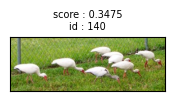

In [21]:
lab.report(include_description=False)

Similarly to the above issue types, we can filter the `odd_aspect_ratio_df` DataFrame to find examples that are considered to have odd aspect ratios. We then sort the filtered results by their `odd_aspect_ratio_score` in ascending order, where examples with the lowest scores have extreme aspect ratios.

In [22]:
odd_aspect_ratio_df = lab.get_issues("odd_aspect_ratio")
odd_aspect_ratio_df = odd_aspect_ratio_df.query(
    "is_odd_aspect_ratio_issue"
).sort_values("odd_aspect_ratio_score", ascending=True)
odd_aspect_ratio_df

odd_aspect_ratio_score  is_odd_aspect_ratio_issue
140                  0.3475                       True

## Advanced Image Dataset Auditing

Like above issue types, `image_issue_types` key can be used for checking specific image issues. The example below shoe how to check specifically for odd_aspect_ratio images.

Please note here that checking for image specific issues is not dependent on `label` column, `pred_probs` or `features`. It only requires the raw `PIL` images and `image_key`.

In [23]:
lab = Datalab(data=dataset_hf, image_key="image")
lab.find_issues(issue_types={"image_issue_types": {"odd_aspect_ratio": {}}})

Finding odd_aspect_ratio images ...


  0%|          | 0/622 [00:00<?, ?it/s]


Audit complete. 1 issues found in the dataset.


Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
odd_aspect_ratio           1

Dataset Information: num_examples: 622






----------------- odd_aspect_ratio images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



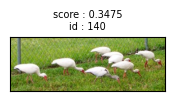

In [24]:
lab.report()

To exert greater control over how a specific image issue type is detected, you can optionally specify non-default hyperparameter values to use when detecting this issue.

For instance: the odd_aspect_ratio issue has a `threshold` hyperparameter, where images with quality score below this threshold are flagged as exhibiting this issue. By changing its value, you can ensure more/less images are flagged as having `odd_aspect_ratio`.

Finding odd_aspect_ratio images ...

Audit complete. 2 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
odd_aspect_ratio           2

Dataset Information: num_examples: 622






----------------- odd_aspect_ratio images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:



/Users/sanjana/cleanlab_home/fork_cleanlab/cleanlab/datalab/internal/adapter/imagelab.py:93: UserWarning: Overwriting columns ['is_odd_aspect_ratio_issue', 'odd_aspect_ratio_score'] in self.issues with columns from imagelab.
  warnings.warn(
/Users/sanjana/cleanlab_home/fork_cleanlab/cleanlab/datalab/internal/adapter/imagelab.py:122: UserWarning: Overwriting ['odd_aspect_ratio'] rows in self.issue_summary from imagelab.
  warnings.warn(
/Users/sanjana/cleanlab_home/fork_cleanlab/cleanlab/datalab/internal/data_issues.py:228: UserWarning: Overwriting key odd_aspect_ratio in self.info
  warnings.warn(f"Overwriting key {issue_name} in self.info")


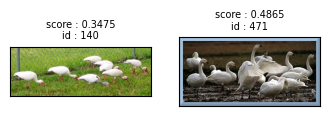

In [25]:
lab.find_issues(
    issue_types={"image_issue_types": {"odd_aspect_ratio": {"threshold": 0.5}}}
)
lab.report()